**Time Series Modeling & Forecasting – Technical Report**

This study focuses on the daily price dynamics of Bitcoin (BTC-USD), obtained from Yahoo Finance, covering the period from January 1, 2018 to March 5, 2025. Bitcoin represents one of the most actively traded and volatile digital assets, making it an informative case for examining return dynamics and time-varying volatility. Because cryptocurrencies operate in a decentralized global market, they frequently experience periods of sharp price swings driven by speculative trading, liquidity events, regulatory announcements, and macroeconomic conditions.

In [3]:
pip install statsmodels arch yfinance scipy

Note: you may need to restart the kernel to use updated packages.


In [5]:
# ============================================================
# Empirical Time Series Modeling & Forecasting: BTC ARIMA–GARCH
# ============================================================

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import jarque_bera

from arch import arch_model

In [7]:
# ---------------------------
# 1) Data download & returns
# ---------------------------

import pandas as pd
import numpy as np
import yfinance as yf

TICKER = "BTC-USD"   # make sure this is a string, not a list
START  = "2018-01-01"
END    = None

data = yf.download(TICKER, start=START, end=END)

# Pick adjusted if available, else close
base_col = "Adj Close" if "Adj Close" in data.columns else "Close"

# Handle both flat columns and MultiIndex columns robustly
if isinstance(data.columns, pd.MultiIndex):
    # yfinance sometimes returns MultiIndex columns when you pass a list of tickers, etc.
    ser = data[base_col][TICKER] if TICKER in data[base_col].columns else data[base_col].iloc[:, 0]
else:
    ser = data[base_col]
    # If this is still a DataFrame (rare, but possible), squeeze to Series
    if isinstance(ser, pd.DataFrame):
        ser = ser.squeeze()

# Clean up and set a proper name
price = ser.dropna()
price.name = "price"

# Compute log returns in percent
ret = np.log(price / price.shift(1)).mul(100).dropna()
ret.name = "ret"

print(price.head())
print(ret.head())

[*********************100%***********************]  1 of 1 completed

Date
2018-01-01    13657.200195
2018-01-02    14982.099609
2018-01-03    15201.000000
2018-01-04    15599.200195
2018-01-05    17429.500000
Name: price, dtype: float64
Date
2018-01-02     9.258926
2018-01-03     1.450509
2018-01-04     2.585843
2018-01-05    11.094453
2018-01-06     0.557838
Name: ret, dtype: float64


In [9]:
price.head()

Date
2018-01-01    13657.200195
2018-01-02    14982.099609
2018-01-03    15201.000000
2018-01-04    15599.200195
2018-01-05    17429.500000
Name: price, dtype: float64

In [11]:
ret.head()

Date
2018-01-02     9.258926
2018-01-03     1.450509
2018-01-04     2.585843
2018-01-05    11.094453
2018-01-06     0.557838
Name: ret, dtype: float64

In [13]:
data.head()

Price,Close,High,Low,Open,Volume
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Date,,,,,
2018-01-01,13657.200195,14112.200195,13154.700195,14112.200195,10291200000
2018-01-02,14982.099609,15444.599609,13163.599609,13625.000000,16846600192
2018-01-03,15201.000000,15572.799805,14844.500000,14978.200195,16871900160
2018-01-04,15599.200195,15739.700195,14522.200195,15270.700195,21783199744
2018-01-05,17429.500000,17705.199219,15202.799805,15477.200195,23840899072


In [15]:
# ---------------------------
# 2) EDA quick look
# ---------------------------
def summ_stats(x):
    return pd.Series({
        "mean": x.mean(),
        "std": x.std(),
        "skew": x.skew(),
        "kurtosis": x.kurtosis(),
        "min": x.min(),
        "max": x.max(),
        "n": x.shape[0],
    })

print("\nSummary stats (returns, %):")
print(summ_stats(ret).round(4))



Summary stats (returns, %):
mean           0.0708
std            3.4458
skew          -0.9675
kurtosis      14.5868
min          -46.4730
max           17.1821
n           2865.0000
dtype: float64


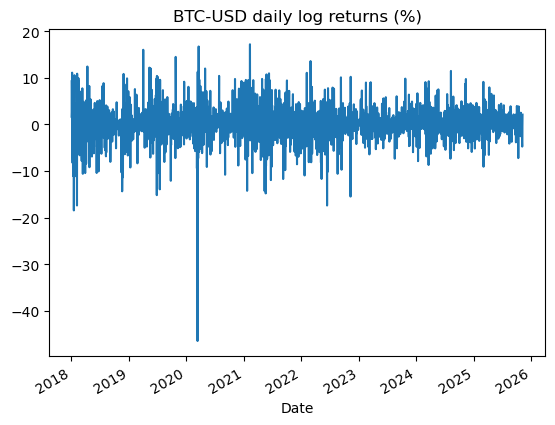

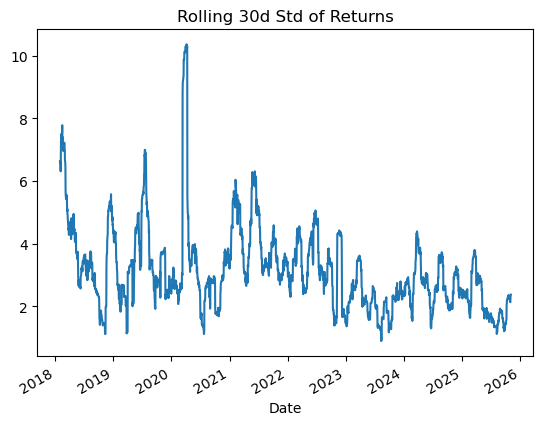

In [17]:
#quick plots
ret.plot(title=f"{TICKER} daily log returns (%)")
plt.show()
ret.rolling(30).std().plot(title="Rolling 30d Std of Returns")
plt.show()

In [19]:
# ---------------------------
# 3) Stationarity tests
# ---------------------------
def adf_test(x):
    res = adfuller(x, autolag="AIC")
    return {"ADF stat": res[0], "p-value": res[1], "lags": res[2], "n": res[3]}

def kpss_test(x):
    # 'ct' (trend) often too strict for returns; 'c' (level) is typical
    stat, pval, lags, crit = kpss(x, regression="c", nlags="auto")
    return {"KPSS stat": stat, "p-value": pval, "lags": lags}

print("\nADF on returns:", adf_test(ret))
try:
    print("KPSS on returns:", kpss_test(ret))
except:
    print("KPSS failed (occasionally occurs with edge cases).")


ADF on returns: {'ADF stat': -18.899685186894583, 'p-value': 0.0, 'lags': 7, 'n': 2857}
KPSS on returns: {'KPSS stat': 0.1471632163406596, 'p-value': 0.1, 'lags': 9}


C:\Users\Ruvarashe\AppData\Local\Temp\ipykernel_23680\1587348375.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  stat, pval, lags, crit = kpss(x, regression="c", nlags="auto")


In [21]:
## ACF and PACF Values
acf_vals = acf(ret, nlags=40)
pacf_vals = pacf(ret, nlags=40, method="ywm")

print("\nACF Values (first 10 lags):")
print(acf_vals[:10])

print("\nPACF Values (first 10 lags):")
print(pacf_vals[:10])


ACF Values (first 10 lags):
[ 1.         -0.04740222  0.04445644  0.00676268  0.02605122  0.01391164
  0.0201575  -0.02236266 -0.02782893  0.00288532]

PACF Values (first 10 lags):
[ 1.00000000e+00 -4.74022248e-02  4.23045291e-02  1.08298688e-02
  2.50761732e-02  1.55615404e-02  1.93338584e-02 -2.23842490e-02
 -3.27048083e-02  8.26625712e-04]


In [23]:
# ---------------------------
# 4) ARIMA order search (small grid)
# ---------------------------
from statsmodels.stats.stattools import jarque_bera  # returns (stat, pvalue, skew, kurtosis)
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch

def fit_arima_and_ic(series, p_max=3, d=0, q_max=3):
    rows = []
    best_model = None
    best_ic = np.inf

    # ensure Series and no NaNs
    series = pd.Series(series).dropna()

    for p in range(p_max + 1):
        for q in range(q_max + 1):
            if p == 0 and q == 0:
                continue
            try:
                # use enforce_stationarity/invertibility off to avoid convergence skips
                model = ARIMA(series, order=(p, d, q), enforce_stationarity=False, enforce_invertibility=False).fit()
                aic, bic = model.aic, model.bic
                rows.append({"p": p, "d": d, "q": q, "AIC": aic, "BIC": bic})
                if np.isfinite(aic) and (aic < best_ic):
                    best_ic = aic
                    best_model = model
            except Exception:
                # silently skip non-convergent or invalid specs
                continue

    ic_df = pd.DataFrame(rows)
    if ic_df.empty or (best_model is None):
        raise RuntimeError("No ARIMA specification converged. Try increasing p_max/q_max or check your data.")

    ic_df = ic_df.sort_values(["AIC", "BIC"])
    return ic_df, best_model

In [25]:
# returns are typically stationary ⇒ d=0
ic_table, arima_fit = fit_arima_and_ic(ret, p_max=3, d=0, q_max=3)
print("\nTop ARIMA by AIC:")
print(ic_table.head(5).round(3))

print("\nChosen ARIMA summary:")
print(arima_fit.summary())

C:\Users\Ruvarashe\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Ruvarashe\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Ruvarashe\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Ruvarashe\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  se


Top ARIMA by AIC:
    p  d  q        AIC        BIC
14  3  0  3  15161.418  15209.089
10  2  0  3  15179.575  15221.287
2   0  0  3  15180.661  15210.455
6   1  0  3  15182.602  15218.355
5   1  0  2  15192.126  15221.923

Chosen ARIMA summary:
                               SARIMAX Results                                
Dep. Variable:                    ret   No. Observations:                 2865
Model:                 ARIMA(3, 0, 3)   Log Likelihood               -7572.709
Date:                Wed, 05 Nov 2025   AIC                          15161.418
Time:                        23:41:48   BIC                          15209.089
Sample:                             0   HQIC                         15178.606
                               - 2865                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------

C:\Users\Ruvarashe\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [27]:
# ---------------------------
# Residual diagnostics
# ---------------------------
# Make sure residuals are a clean 1-D Series with no NaNs/Infs
arima_resid = pd.Series(arima_fit.resid).replace([np.inf, -np.inf], np.nan).dropna()

# Ljung–Box portmanteau test for autocorrelation in residuals
lb = acorr_ljungbox(arima_resid, lags=[10, 20], return_df=True)

# Jarque–Bera normality test (statsmodels version returns 4 values)
jb_stat, jb_p, jb_skew, jb_kurt = jarque_bera(arima_resid)

# Engle's ARCH LM test for conditional heteroscedasticity (set lags explicitly)
arch_lm_stat, arch_lm_p, arch_f_stat, arch_f_p = het_arch(arima_resid, nlags=12)

print("\nLjung–Box p-values:\n", lb["lb_pvalue"])
print(f"Jarque–Bera: stat={jb_stat:.3f}, p={jb_p:.4f}, skew={jb_skew:.3f}, kurtosis={jb_kurt:.3f}")
print(f"ARCH LM (nlags=12): LM p-value={arch_lm_p:.4f}, F p-value={arch_f_p:.4f}")




Ljung–Box p-values:
 10    0.692538
20    0.696276
Name: lb_pvalue, dtype: float64
Jarque–Bera: stat=25005.060, p=0.0000, skew=-0.959, kurtosis=17.345
ARCH LM (nlags=12): LM p-value=0.0000, F p-value=0.0000


In [9]:
# 5) GARCH-family on ARIMA residuals
#    We'll fit GARCH(1,1) and EGARCH(1,1) with normal & t errors
# ---------------------------
def fit_vol_models(resid):
    out = {}
    for dist in ["normal", "t"]:
        # GARCH(1,1)
        g = arch_model(resid, vol="GARCH", p=1, q=1, mean="Zero", dist=dist)
        g_res = g.fit(disp="off")
        out[f"GARCH11_{dist}"] = g_res

        # EGARCH(1,1)
        eg = arch_model(resid, vol="EGARCH", p=1, q=1, mean="Zero", dist=dist)
        eg_res = eg.fit(disp="off")
        out[f"EGARCH11_{dist}"] = eg_res
    return out

vol_fits = fit_vol_models(arima_resid)
print("\nVolatility model AICs:")
for name, res in vol_fits.items():
    print(f"{name:>16}: AIC={res.aic:.2f}, BIC={res.bic:.2f}")



Volatility model AICs:
  GARCH11_normal: AIC=14822.77, BIC=14840.65
 EGARCH11_normal: AIC=14834.56, BIC=14852.45
       GARCH11_t: AIC=14124.88, BIC=14148.72
      EGARCH11_t: AIC=14102.07, BIC=14125.91


In [10]:
# 6) Rolling one-step-ahead forecasts (walk-forward)
#    We forecast mean via ARIMA, variance via chosen GARCH model
# ---------------------------
TEST_LEN = 250  # ~1 year of trading days
train_ret = ret.iloc[:-TEST_LEN].copy()
test_ret  = ret.iloc[-TEST_LEN:].copy()

# Refit ARIMA on expanding window; forecast one-step ahead mean
def rolling_forecast_arima(series, order, test_len):
    preds = []
    idx = series.index
    for i in range(test_len):
        end = len(series) - test_len + i
        train = series.iloc[:end]
        try:
            m = ARIMA(train, order=order).fit()
            f = m.get_forecast(1).predicted_mean.iloc[0]
        except:
            f = 0.0
        preds.append(f)
    return pd.Series(preds, index=series.index[-test_len:])

chosen_order = arima_fit.model_orders  # dict in statsmodels >=0.13
p = chosen_order.get("ar", 0)
q = chosen_order.get("ma", 0)
order_tuple = (p, 0, q)
mean_fc = rolling_forecast_arima(ret, order_tuple, TEST_LEN)

# For volatility, we refit EGARCH(1,1) with t errors on the residuals from each step’s ARIMA
def rolling_vol_forecast(series, order, test_len):
    vol_preds = []
    for i in range(test_len):
        end = len(series) - test_len + i
        train = series.iloc[:end]
        # fit ARIMA on train and get residuals
        m = ARIMA(train, order=order).fit()
        resid = m.resid
        # fit EGARCH(1,1)-t on residuals and forecast variance one-step ahead
        eg = arch_model(resid, vol="EGARCH", p=1, q=1, mean="Zero", dist="t").fit(disp="off")
        vf = eg.forecast(horizon=1).variance.iloc[-1,0]  # next-day variance
        vol_preds.append(float(vf))
    return pd.Series(vol_preds, index=series.index[-test_len:])

vol_fc = rolling_vol_forecast(ret, order_tuple, TEST_LEN)


c:\Users\Ruvarashe\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Ruvarashe\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Ruvarashe\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Ruvarashe\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Ruvarashe\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so in

In [13]:
# ---------------------------
# 7) Accuracy metrics
# ---------------------------
def metrics(y_true, y_pred):
    err = y_true - y_pred
    rmse = np.sqrt(np.mean(err**2))
    mae  = np.mean(np.abs(err))
    mape = np.mean(np.abs(err / (np.where(y_true==0, np.nan, y_true)))) * 100
    return {"RMSE": rmse, "MAE": mae, "MAPE(%)": mape}

mean_metrics = metrics(test_ret, mean_fc)
print("\nMean Forecast Metrics (ARIMA):", {k: round(v,4) for k,v in mean_metrics.items()})

# Simple volatility “check”: standardized residuals using predicted variance
# Note: We align one-step-ahead var forecast with actual next-day residuals from ARIMA refits above.
# As an approximation, reuse the last ARIMA fit for residuals over test; for precise alignment, store each step residual.
test_err = test_ret - mean_fc
std_resid = test_err / np.sqrt(vol_fc)
lb_std = acorr_ljungbox(std_resid.replace([np.inf, -np.inf], np.nan).dropna(), lags=[10,20], return_df=True)
print("\nLjung–Box on standardized residuals (vol forecasts) p-values:\n", lb_std["lb_pvalue"])


Mean Forecast Metrics (ARIMA): {'RMSE': 2.2135, 'MAE': 1.5526, 'MAPE(%)': 137.9673}

Ljung–Box on standardized residuals (vol forecasts) p-values:
 10    0.880434
20    0.884185
Name: lb_pvalue, dtype: float64


In [14]:


# ---------------------------
# 8) Save key outputs (optional)
# ---------------------------
results = pd.DataFrame({
    "ret": test_ret,
    "mean_fc": mean_fc,
    "vol_fc": vol_fc
})
# results.to_csv("btc_arima_garch_out_of_sample.csv")
print("\nHead of test vs forecasts:")
print(results.head().round(4))



Head of test vs forecasts:
               ret  mean_fc   vol_fc
Date                                
2025-03-01  1.9471  -0.1506   8.0618
2025-03-02  9.1215  -0.2460   8.2663
2025-03-03 -9.0823  -0.2183  13.6402
2025-03-04  1.3348   0.9384  19.1944
2025-03-05  3.8255  -0.0297  17.3369
